In [4]:
import sys
import os
cwd = os.getcwd()
sys.path.append('C://Users//bclamber//Documents//GitHub//pints')
from __future__ import print_function
import pints
import pints.toy as toy
import pints._diagnostics as diagnostics
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.LogPosterior(prior, log_likelihood)

# Create an adaptive covariance MCMC routine
x0 = real_parameters * 1.1
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)

# Aim for an acceptance rate of 0.3
mcmc.set_acceptance_rate(0.3)

# Use 4000 iterations in total
mcmc.set_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_non_adaptive_iterations(1000)

# Discard the first 2000 iterations as burn in
mcmc.set_burn_in(2000)

# Store only every 4th sample
mcmc.set_thinning_rate(4)

# Disable verbose mode
mcmc.set_verbose(False)

# Number of chains
num_chains = 4

# Run 4 chains - needs to be part of default call to MCMC objects
print('Running...')
chains = []
for i in range(0,num_chains):
    chain = mcmc.run()
    chains.append(chain)
print('Done!')

result = pints.McmcResultObject(chains)

Running...
Done!


In [3]:
result.print_summary()

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
param 1  0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.00    460.05
param 2  500.29  0.49    499.34  499.95  500.29  500.62  501.23   1.00    417.08
param 3  10.01   0.23    9.59    9.86    10.01   10.17   10.47    1.00    423.15


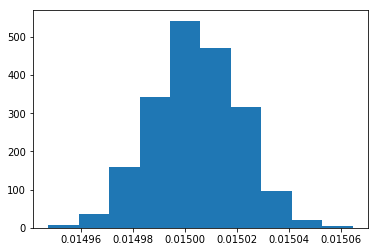

In [5]:
# extract samples for parameter number 0
samples_0 = result.extract(0)

# plot them
plt.hist(samples_0)
plt.show()